In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = pd.read_csv("datos_modelos.csv")

# Regresión logística

In [ ]:
# ----------- PREPROCESAMIENTO ----------- #
# Convertir 'sexo' en dummie (0: hombre, 1: mujer)
df['sexo'] = df['sexo'].str.lower().map({'masculino': 0, 'femenino': 1})

# Limpiar 'actividadfisica': TRUE → 1, FALSE o NaN → 0
df['actividadfisica'] = df['actividadfisica'].astype(str).str.upper().map({'TRUE': 1}).fillna(0).astype(int)

X = df[['PC1', 'PC2', 'PC3', 'sexo', 'hta', 'dm', 'actividadfisica']]
y = df['rcv']

# ----------- DIVISIÓN DE DATOS ----------- #
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# ----------- MODELOS ----------- #
model_base = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
model_reg = LogisticRegression(penalty='l2', C=0.01, solver='liblinear')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cross_validate_model(model, X, y):
    metrics_list = []
    y_prob_all, y_true_all, y_pred_all = [], [], []

    for train_idx, val_idx in skf.split(X, y):
        X_t, X_v = X.iloc[train_idx], X.iloc[val_idx]
        y_t, y_v = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_t, y_t)
        y_pred = model.predict(X_v)
        y_prob = model.predict_proba(X_v)[:, 1]

        tn, fp, fn, tp = confusion_matrix(y_v, y_pred).ravel()
        metrics = {
            'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
            'Accuracy': (tp + tn) / (tp + tn + fp + fn),
            'Precision': precision_score(y_v, y_pred),
            'Recall': recall_score(y_v, y_pred),
            'F1': f1_score(y_v, y_pred),
            'AUC': roc_auc_score(y_v, y_prob),
            'AP': average_precision_score(y_v, y_prob)
        }
        metrics_list.append(metrics)
        y_prob_all.extend(y_prob)
        y_true_all.extend(y_v)
        y_pred_all.extend(y_pred)

    return pd.DataFrame(metrics_list), np.array(y_true_all), np.array(y_pred_all), np.array(y_prob_all)

In [ ]:
# ----------- VALIDACIÓN CRUZADA ----------- #
base_metrics, y_base_true, y_base_pred, y_base_prob = cross_validate_model(model_base, X_train, y_train)
reg_metrics, y_reg_true, y_reg_pred, y_reg_prob = cross_validate_model(model_reg, X_train, y_train)


# Añadir columna que identifique cada modelo
base_metrics['Modelo'] = 'Base (C=1)'
reg_metrics['Modelo'] = 'Reg Fuerte (C=0.01)'

# Unir ambos DataFrames
all_metrics = pd.concat([base_metrics, reg_metrics], ignore_index=True)

# Mostrar promedios de cada métrica por modelo
print("Promedio de métricas por modelo:\n")
print(all_metrics.groupby('Modelo').mean().round(3).T)

# ----------- COEFICIENTES ----------- #
model_base.fit(X_train, y_train)
model_reg.fit(X_train, y_train)

coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Base': model_base.coef_[0],
    'Reg_Fuerte': model_reg.coef_[0]
})
coef_df.set_index('Variable', inplace=True)

Promedio de métricas por modelo:

Modelo     Base (C=1)  Reg Fuerte (C=0.01)
TP            190.600              193.400
FP             24.600               49.200
TN            330.400              305.800
FN             54.400               51.600
Accuracy        0.868                0.832
Precision       0.886                0.798
Recall          0.778                0.789
F1              0.828                0.793
AUC             0.930                0.911
AP              0.914                0.879


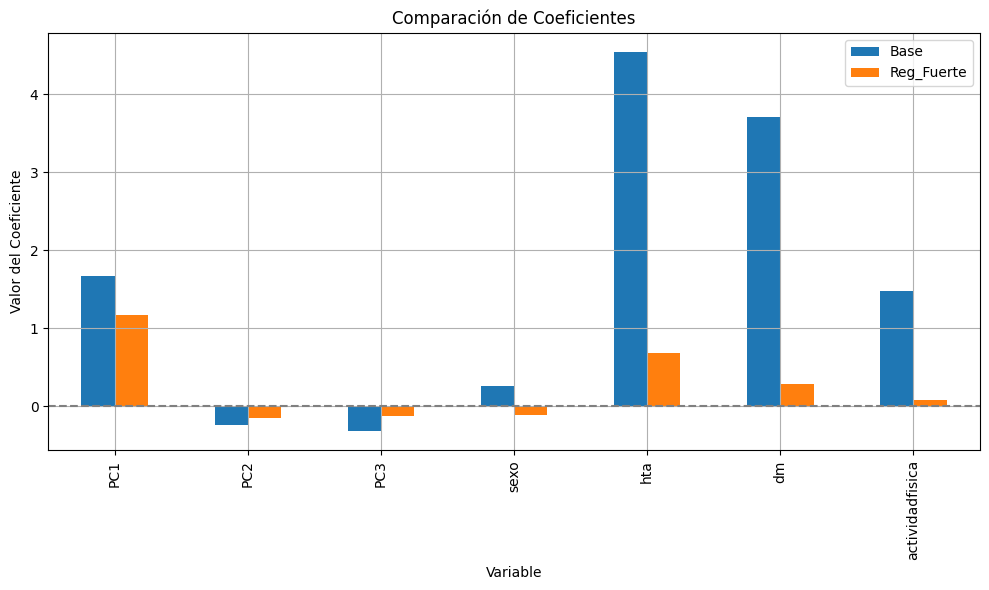

In [ ]:
# ----------- GRÁFICO 1: COEFICIENTES ----------- #
coef_df.plot(kind='bar', figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.title('Comparación de Coeficientes')
plt.ylabel('Valor del Coeficiente')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ----------- MATRICES DE CONFUSIÓN EN TEXTO ----------- #
def print_confusion_matrix(y_true, y_pred, nombre_modelo):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n Matriz de Confusión - {nombre_modelo}")
    print(f"           Pred 0   Pred 1")
    print(f"Real 0     {tn:7d} {fp:7d}")
    print(f"Real 1     {fn:7d} {tp:7d}")

print_confusion_matrix(y_base_true, y_base_pred, 'Modelo Base')
print_confusion_matrix(y_reg_true, y_reg_pred, 'Modelo Regularizado')


 Matriz de Confusión - Modelo Base
           Pred 0   Pred 1
Real 0        1652     123
Real 1         272     953

 Matriz de Confusión - Modelo Regularizado
           Pred 0   Pred 1
Real 0        1529     246
Real 1         258     967


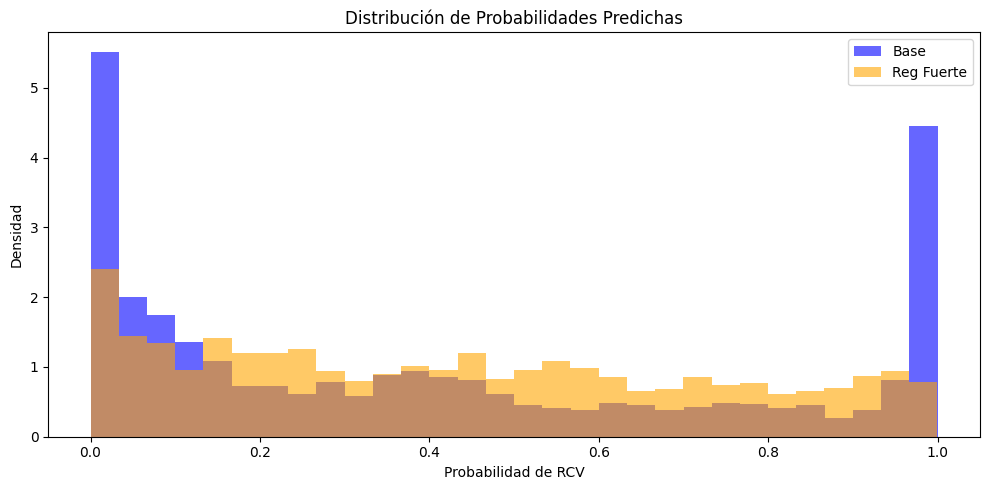

In [ ]:
# ----------- HISTOGRAMA DE PROBABILIDADES CON MATPLOTLIB ----------- #
plt.figure(figsize=(10,5))
plt.hist(y_base_prob, bins=30, alpha=0.6, color='blue', label='Base', density=True)
plt.hist(y_reg_prob, bins=30, alpha=0.6, color='orange', label='Reg Fuerte', density=True)
plt.title('Distribución de Probabilidades Predichas')
plt.xlabel('Probabilidad de RCV')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()

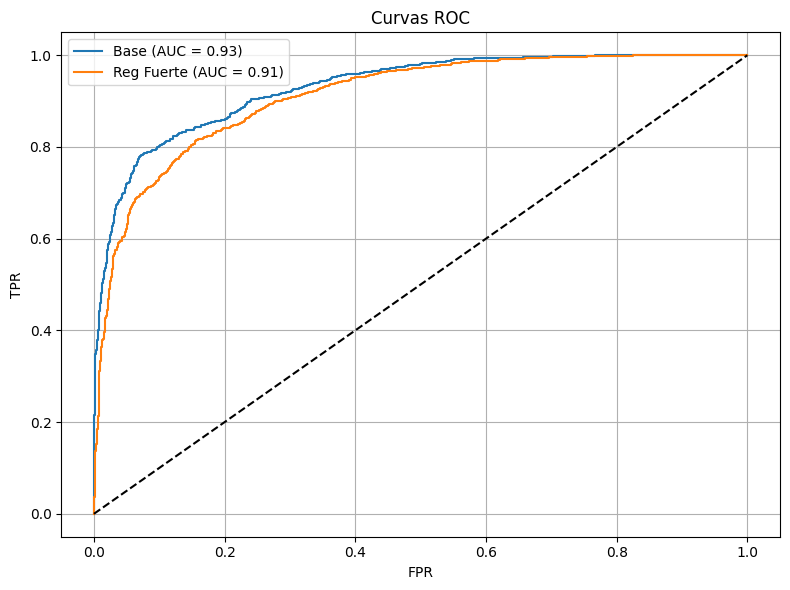

In [ ]:
# ----------- GRÁFICO 3: CURVA ROC ----------- #
fpr_base, tpr_base, _ = roc_curve(y_base_true, y_base_prob)
fpr_reg, tpr_reg, _ = roc_curve(y_reg_true, y_reg_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr_base, tpr_base, label='Base (AUC = {:.2f})'.format(roc_auc_score(y_base_true, y_base_prob)))
plt.plot(fpr_reg, tpr_reg, label='Reg Fuerte (AUC = {:.2f})'.format(roc_auc_score(y_reg_true, y_reg_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

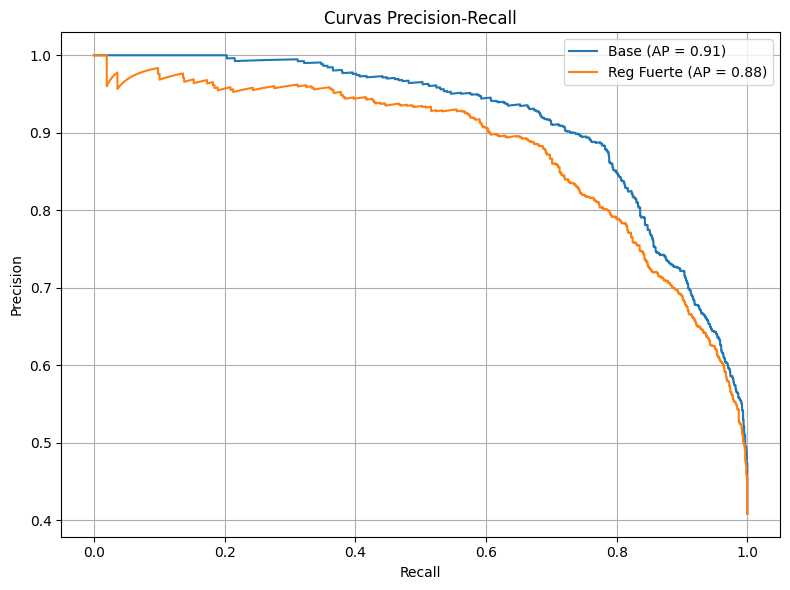

In [ ]:
# ----------- GRÁFICO 4: CURVA PRECISION-RECALL ----------- #
prec_base, rec_base, _ = precision_recall_curve(y_base_true, y_base_prob)
prec_reg, rec_reg, _ = precision_recall_curve(y_reg_true, y_reg_prob)

plt.figure(figsize=(8,6))
plt.plot(rec_base, prec_base, label='Base (AP = {:.2f})'.format(average_precision_score(y_base_true, y_base_prob)))
plt.plot(rec_reg, prec_reg, label='Reg Fuerte (AP = {:.2f})'.format(average_precision_score(y_reg_true, y_reg_prob)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ----------- TABLA FINAL COMPARATIVA ----------- #
print("\n Tabla Resumen Promedios (Validación Cruzada)")

# Filtramos solo las columnas numéricas (las métricas)
metricas_base = base_metrics.select_dtypes(include='number').mean()
metricas_reg = reg_metrics.select_dtypes(include='number').mean()

# Crear tabla resumen
resumen = pd.DataFrame({
    'Métrica': metricas_base.index,
    'Modelo Base': metricas_base.values,
    'Reg. Fuerte': metricas_reg.values
}).round(3)

print(resumen.to_string(index=False))



 Tabla Resumen Promedios (Validación Cruzada)
  Métrica  Modelo Base  Reg. Fuerte
       TP      190.600      193.400
       FP       24.600       49.200
       TN      330.400      305.800
       FN       54.400       51.600
 Accuracy        0.868        0.832
Precision        0.886        0.798
   Recall        0.778        0.789
       F1        0.828        0.793
      AUC        0.930        0.911
       AP        0.914        0.879


# Random Forest

In [ ]:
# ----------- MODELO RANDOM FOREST ----------- #
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Evaluamos usando la función de validación cruzada
rf_metrics, y_rf_true, y_rf_pred, y_rf_prob = cross_validate_model(model_rf, X_train, y_train)

# ----------- PROMEDIO DE MÉTRICAS ----------- #
print("Promedio de métricas (Random Forest - Validación Cruzada):\n")
print(rf_metrics.mean(numeric_only=True).round(3))


Promedio de métricas (Random Forest - Validación Cruzada):

TP           213.600
FP            24.600
TN           330.400
FN            31.400
Accuracy       0.907
Precision      0.897
Recall         0.872
F1             0.884
AUC            0.967
AP             0.954
dtype: float64


In [ ]:
# ----------- MATRIZ DE CONFUSIÓN ----------- #
print_confusion_matrix(y_rf_true, y_rf_pred, 'Random Forest')


 Matriz de Confusión - Random Forest
           Pred 0   Pred 1
Real 0        1652     123
Real 1         157    1068


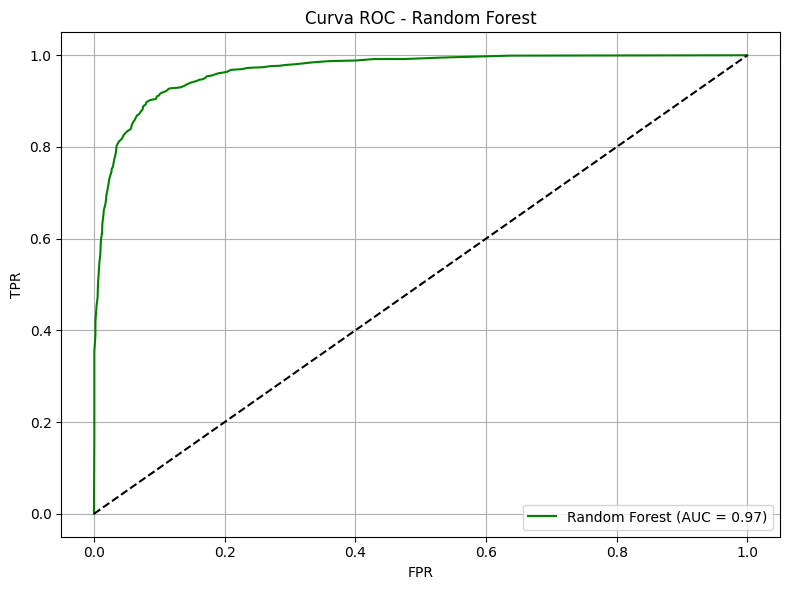

In [ ]:
# ----------- CURVA ROC ----------- #
from sklearn.metrics import roc_curve, roc_auc_score

fpr_rf, tpr_rf, _ = roc_curve(y_rf_true, y_rf_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_rf_true, y_rf_prob)), color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

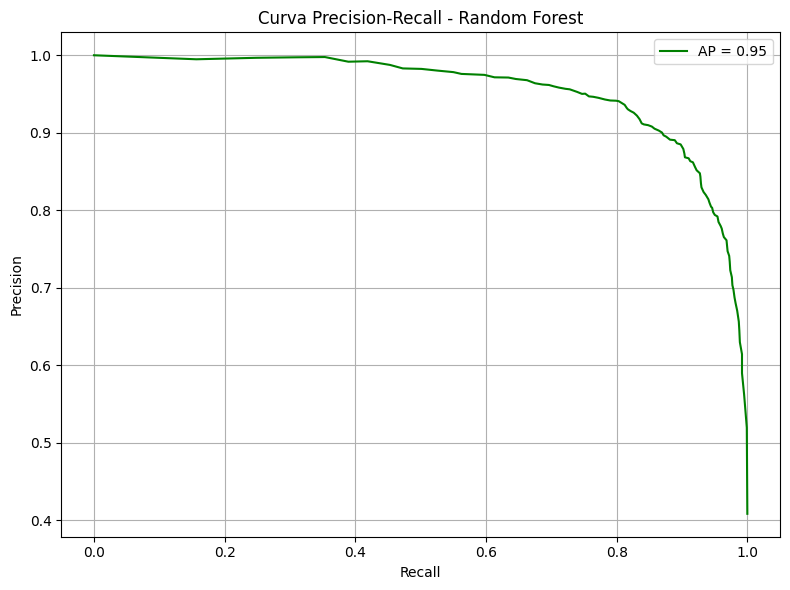

In [ ]:
# ----------- CURVA PRECISION-RECALL ----------- #
from sklearn.metrics import precision_recall_curve, average_precision_score

prec_rf, rec_rf, _ = precision_recall_curve(y_rf_true, y_rf_prob)

plt.figure(figsize=(8,6))
plt.plot(rec_rf, prec_rf, label='AP = {:.2f}'.format(average_precision_score(y_rf_true, y_rf_prob)), color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

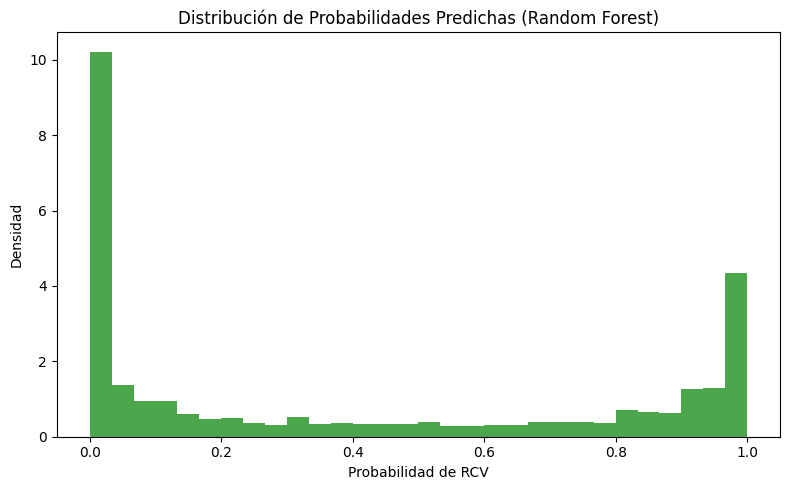

In [ ]:
# ----------- HISTOGRAMA DE PROBABILIDADES ----------- #
plt.figure(figsize=(8,5))
plt.hist(y_rf_prob, bins=30, alpha=0.7, color='green', density=True)
plt.title('Distribución de Probabilidades Predichas (Random Forest)')
plt.xlabel('Probabilidad de RCV')
plt.ylabel('Densidad')
plt.tight_layout()
plt.show()

# Resultados juntos

In [ ]:
# Añadir columna que identifique el modelo
rf_metrics['Modelo'] = 'Random Forest'

# ----------- UNIR TODOS LOS MODELOS ----------- #
all_metrics = pd.concat([base_metrics, reg_metrics, rf_metrics], ignore_index=True)

# ----------- PROMEDIOS DE MÉTRICAS ----------- #
print("Promedio de métricas por modelo:\n")
print(all_metrics.groupby('Modelo').mean().round(3).T)

Promedio de métricas por modelo:

Modelo     Base (C=1)  Random Forest  Reg Fuerte (C=0.01)
TP            190.600        213.600              193.400
FP             24.600         24.600               49.200
TN            330.400        330.400              305.800
FN             54.400         31.400               51.600
Accuracy        0.868          0.907                0.832
Precision       0.886          0.897                0.798
Recall          0.778          0.872                0.789
F1              0.828          0.884                0.793
AUC             0.930          0.967                0.911
AP              0.914          0.954                0.879


In [ ]:
# ----------- MATRICES DE CONFUSIÓN ----------- #
print_confusion_matrix(y_rf_true, y_rf_pred, 'Random Forest')



 Matriz de Confusión - Random Forest
           Pred 0   Pred 1
Real 0        1652     123
Real 1         157    1068


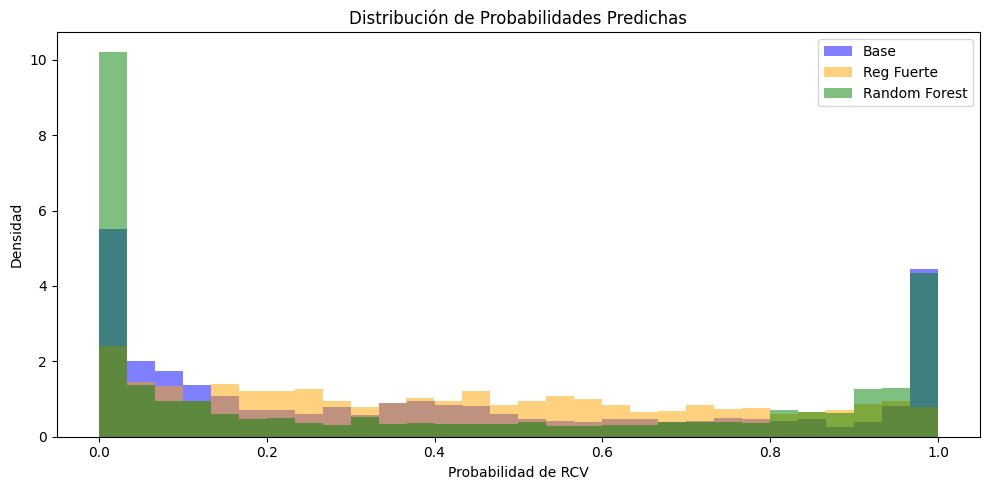

In [ ]:
# ----------- HISTOGRAMA DE PROBABILIDADES ----------- #
plt.figure(figsize=(10,5))
plt.hist(y_base_prob, bins=30, alpha=0.5, color='blue', label='Base', density=True)
plt.hist(y_reg_prob, bins=30, alpha=0.5, color='orange', label='Reg Fuerte', density=True)
plt.hist(y_rf_prob, bins=30, alpha=0.5, color='green', label='Random Forest', density=True)
plt.title('Distribución de Probabilidades Predichas')
plt.xlabel('Probabilidad de RCV')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()

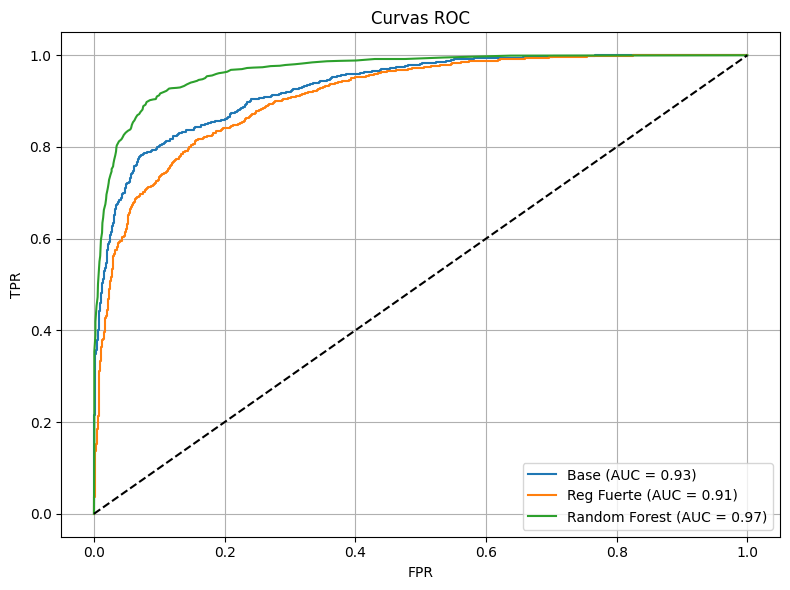

In [ ]:
# ----------- CURVA ROC ----------- #
fpr_rf, tpr_rf, _ = roc_curve(y_rf_true, y_rf_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr_base, tpr_base, label='Base (AUC = {:.2f})'.format(roc_auc_score(y_base_true, y_base_prob)))
plt.plot(fpr_reg, tpr_reg, label='Reg Fuerte (AUC = {:.2f})'.format(roc_auc_score(y_reg_true, y_reg_prob)))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_rf_true, y_rf_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

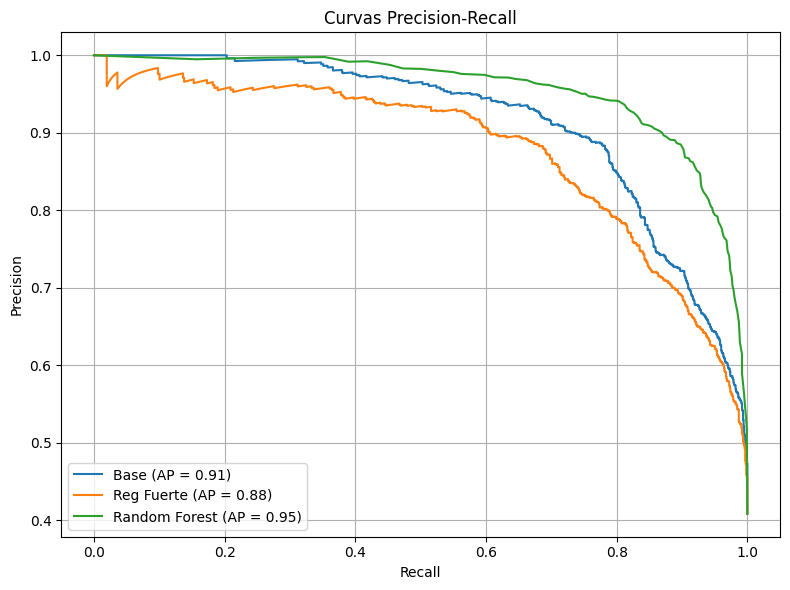

In [ ]:
# ----------- CURVA PRECISION-RECALL ----------- #
prec_rf, rec_rf, _ = precision_recall_curve(y_rf_true, y_rf_prob)

plt.figure(figsize=(8,6))
plt.plot(rec_base, prec_base, label='Base (AP = {:.2f})'.format(average_precision_score(y_base_true, y_base_prob)))
plt.plot(rec_reg, prec_reg, label='Reg Fuerte (AP = {:.2f})'.format(average_precision_score(y_reg_true, y_reg_prob)))
plt.plot(rec_rf, prec_rf, label='Random Forest (AP = {:.2f})'.format(average_precision_score(y_rf_true, y_rf_prob)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ----------- TABLA FINAL COMPARATIVA ----------- #
print("\n Tabla Resumen Promedios (Validación Cruzada)")

metricas_rf = rf_metrics.select_dtypes(include='number').mean()

resumen = pd.DataFrame({
    'Métrica': metricas_base.index,
    'Modelo Base': metricas_base.values,
    'Reg. Fuerte': metricas_reg.values,
    'Random Forest': metricas_rf.values
}).round(3)

print(resumen.to_string(index=False))


 Tabla Resumen Promedios (Validación Cruzada)
  Métrica  Modelo Base  Reg. Fuerte  Random Forest
       TP      190.600      193.400        213.600
       FP       24.600       49.200         24.600
       TN      330.400      305.800        330.400
       FN       54.400       51.600         31.400
 Accuracy        0.868        0.832          0.907
Precision        0.886        0.798          0.897
   Recall        0.778        0.789          0.872
       F1        0.828        0.793          0.884
      AUC        0.930        0.911          0.967
       AP        0.914        0.879          0.954


In [ ]:
datos_finales = pd.concat([
    X_train.reset_index(drop=True),
    y_train.reset_index(drop=True),
    pd.Series(y_base_pred, name='y_base_pred'),
    pd.Series(y_reg_pred, name='y_reg_pred'),
    pd.Series(y_rf_pred, name='y_rf_pred')
], axis=1)

datos_finales.to_csv("datos_finales.csv")